<a href="https://colab.research.google.com/github/idrissdeme/Aulas-Python-IRD/blob/main/C%C3%B3pia_de_Curso_Verao_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link para a apresentação: [shorturl.at/uxyR8](http://shorturl.at/uxyR8)

# Vamos gerar dados artificiais com componentes


*   linear
*   quadrática
*   oscilatória

e vamos adicionar

*   ruido

A idéia é simular um possível resultado de um experimento, por exemplo


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# synthetic data
x_min, x_max, n_points = 0, 5, 200
x = np.linspace(x_min, x_max, n_points)
y_linear = 2 - 1.4*x
y_quadratic = 4 * (x-2)**2
y_wiggle = 2 * np.cos(5*x)
noise_std = 2
y_noise = noise_std * (np.random.random(len(x)) - 0.5)

y_real = y_linear + y_quadratic + y_wiggle
y_noisy = y_real + y_noise

In [ ]:
# Mais tarde, teste como a renormalização afeta o treinamento
# Isto seria um pre-processamento dos dados, com o objetivo de deixá-los mais "mastigados"
# para o computador

# Coloque aqui seu código para renormalizar x: deixar com média = 0 e desvio padrão = 1: x ~ N(0, 1)
# ...

# Coloque aqui seu código para renormalizar y_real e y_noise: deixar com média = 0 e desvio padrão = 1: y ~ N(0, 1)
# ...

# Você pode testar renormalizar apenas x, apenas y, e ambos

#x_data, _, y_data, _ = train_test_split(x, y_noisy, train_size=n_keep)

In [ ]:
# seleciona alguns pontos aleatoriamente
# mais tarde, teste como a quantidade de dados afeta a regressão
n_keep = 0 # escolha um número

x_data, _, y_data, _ = train_test_split(x, y_noisy, train_size=n_keep)

Aqui estão nossos dados!

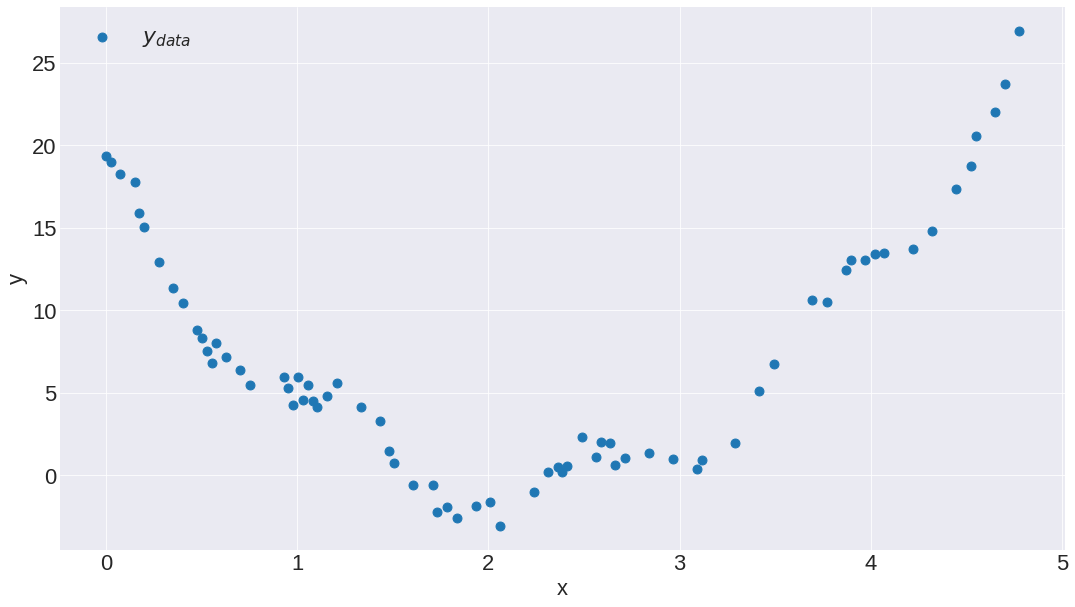

In [ ]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [18, 10]
plt.rcParams['font.size'] = 22
plt.style.use('seaborn-darkgrid')
s = 80
lw = 3

#plt.plot(x, y_real, '--', label='$y_{real}$')
plt.scatter(x_data, y_data, label='$y_{data}$', s=s)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Se você recebesse os dados acima, que tipo de função saria para modelá-los?

Vamos testar algumas funções modelo agora:

In [ ]:
# Esta classe serve para salvar o histórico de parâmetros durante a otimização,
# e para imprimir as funções modelo "bonitinhas", ou seja,
# apenas para estética e visualização.
# Não se preocupe se não entender

from typing import Callable

# need this class to automatically save parameters history
# models are initialized by specifying:
# - a function or lambda, 
# - a format string to print the function, 
# - and an optional initial parameters list (if not given, they are initialized randomly)
class ModelFunction:
  def __init__(self, func: Callable, repr: str, params=None):
    self.f = func
    self.n_params = func.__code__.co_argcount - 1
    self.repr = repr
    self.params = np.random.random(self.n_params) if params is None else np.array(params)
    self.params_history = []
    self.freeze = False
    self.record = False
    self.pcov = None
    self.perr = None
  
  def __call__(self, x, *params):
    if(not self.freeze and len(params) == len(self.params)):
      self.params = np.array(params)
    if self.record and not np.any([self.params == p for p in self.params_history]):
      self.params_history.append(self.params)
    p = self.params if len(params)==0 else params
    return self.f(x, *p)
  
  def __repr__(self):
    return self.repr % tuple(self.params)

  def set_pcov(self, pcov):
    self.pcov = pcov
    self.perr = np.sqrt(np.diag(pcov)) 
  
  def show(self):
    if self.pcov is None:
      s = self.__repr__
    else:
      r = self.repr.replace('%.2g', '(%.2g ± %.2g)')
      v = tuple([elem for sublist in list(zip(self.params, self.perr)) for elem in sublist])
      s = r % v
    print(s)

Ajustando a função modelo:
<bound method ModelFunction.__repr__ of 0.84 + 0.5 x + 0.36 x²>
Resultado final:
(18 ± 0.47) + (-17 ± 0.49) x + (3.8 ± 0.1) x²

Ajustando a função modelo:
<bound method ModelFunction.__repr__ of 0 + 0 x + 0 x² + 2 cos(4.5 x)>
Resultado final:
(18 ± 0.18) + (-17 ± 0.19) x + (3.9 ± 0.039) x² + (2 ± 0.096) cos((5 ± 0.019) x)

Ajustando a função modelo:
<bound method ModelFunction.__repr__ of -1e+06 + -2e+03 x + 1e+06 exp(0.002 x)>
Resultado final:
(-1e+06 ± 1.5e+07) + (-2.8e+03 ± 2e+04) x + (1e+06 ± 1.5e+07) exp((0.0027 ± 0.019) x)



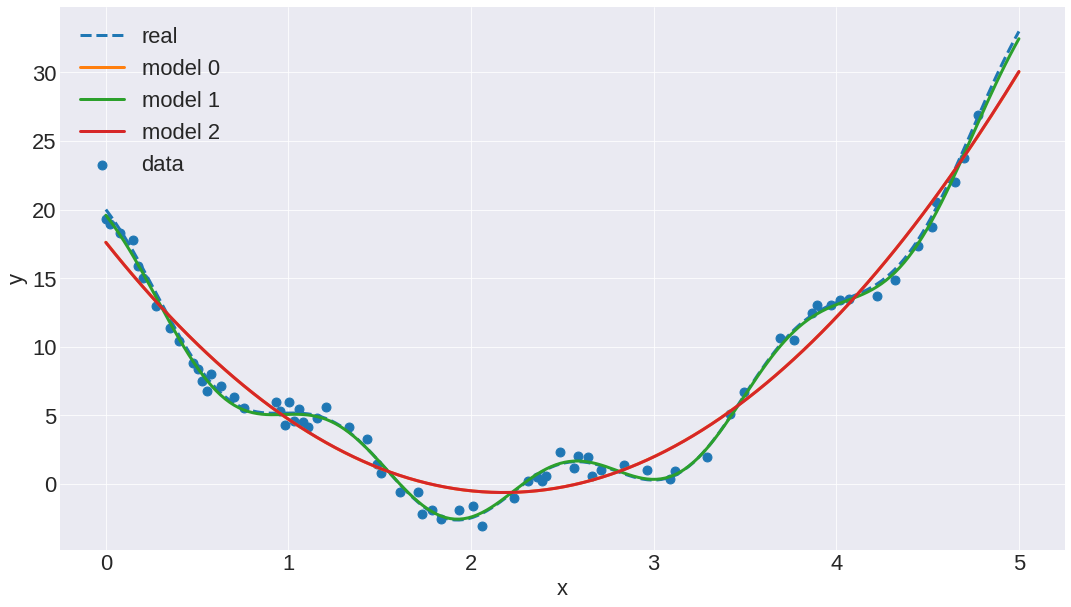

In [ ]:
from scipy.optimize import curve_fit


# Lista com as funções modelo que vamos ajustar aos dados.
# Cada elemento da lista é uma instância da classe ModelFunction acima e recebe como entrada:
#  - uma função ou lambda (precisa ter a ordem f(x, a0, a1, ...), isso é requerimento da função curve_fit)
#  - uma string para formatação (para imprimir a função "bonitinha")
#  - opcionalmente, uma lista com os valores iniciais dos parâmetros (se não tiver, serão inicializados aleatoriamente)
f_models = [
    ModelFunction(lambda x, a0, a1, a2: a0 + a1*x + a2*x**2,
                  '%.2g + %.2g x + %.2g x²'),
    ModelFunction(lambda x, a0, a1, a2, b0, b1: a0 + a1*x + a2*x**2 + b0*np.cos(b1*x),
                  '%.2g + %.2g x + %.2g x² + %.2g cos(%.2g x)', [0., 0., 0., 2., 4.5]),  # tente inizialar aleatoriamente ou com zeros
    ModelFunction(lambda x, a0, a1, a2, a3: a0 + a1*x + a2*np.exp(a3*x),
                  '%.2g + %.2g x + %.2g exp(%.2g x)', [-1e6, -2e3, 1e6, .002]),          # tente inizialar aleatoriamente ou com zeros
]

# lista para guardar os parâmetros otimizados das funções modelo
model_params = []
# lista para guardar as covariâncias (lembre: ML = estatística + hype)
model_cov = []
# lista para guardar os erros (calculados das covariâncias)
model_err = []

# lista para guardar os valores (y) das funções modelo já otimizadas (fitted)
y_fits = []

# loop sobre as funções
for f_ in f_models:
  print('Ajustando a função modelo:')
  f_.show()

  f_.record = True    # salva o histórico
  
  popt, pcov = curve_fit( f_, x_data, y_data, p0=f_.params, maxfev=50000 )
  
  f_.set_pcov(pcov)   # save parameter covariances

  model_params.append( popt )                    # salva os parâmetros otimizados na nossa lista
  model_cov.append( pcov )                       # salva as covariâncias na nossa lista
  model_err.append( np.sqrt( np.diag(pcov) ) )   # calcula e salva os erros no ajuste dos parâmetros na nossa lista
  y_fits.append( f_(x, *popt) )                  # calcula e salva os valores y das funções otimizadas

  print('Resultado final:')
  f_.show()
  print('')


plt.scatter(x_data, y_data, label='data', s=s)
plt.plot(x, y_real, '--', label='real', lw=lw)
for i, y_ in enumerate(y_fits):
  plt.plot(x, y_, label='model %d' % i, lw=lw)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Como podemos determinar se o modelo é bom ou não?

* https://en.wikipedia.org/wiki/Goodness_of_fit
* https://en.wikipedia.org/wiki/Coefficient_of_determination

In [ ]:
from sklearn.metrics import r2_score

for i, f_ in enumerate(f_models):
  print('model %d has R²=%g' % (i, r2_score(y_data, f_(x_data, *model_params[i]))))

model 0 has R²=0.956123
model 1 has R²=0.99403
model 2 has R²=0.956022


## Vamos visualizar o processo de otimização dos parâmetros para um modelo

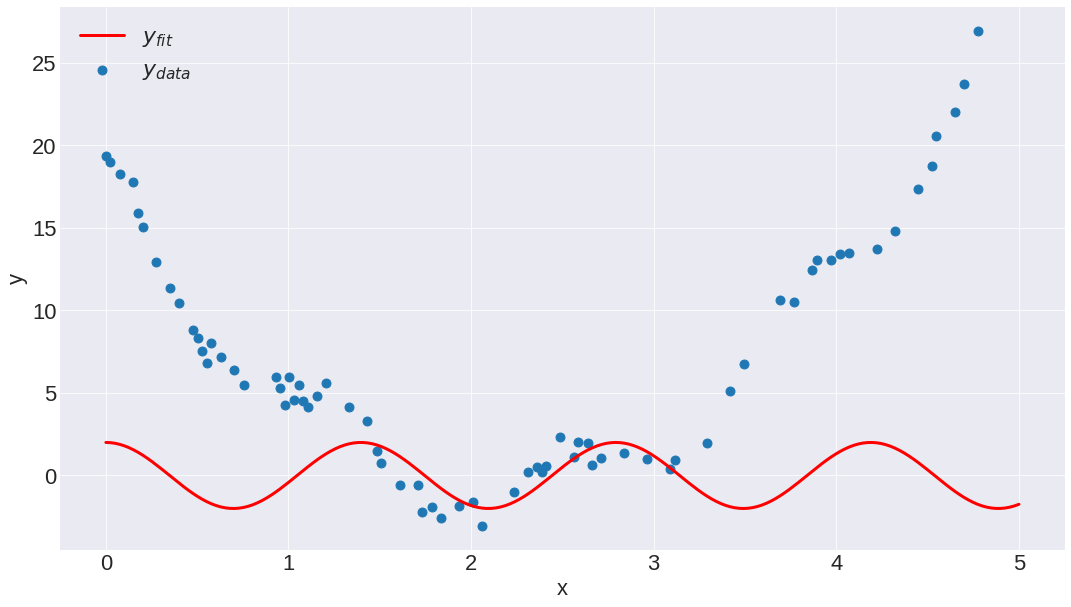

In [ ]:
# escolha o índice do modelo que você quer investigar
n = 1

f_model = f_models[n]  

# calcula as curvas ao longo do processo de otimização
y_fit_hist = [f_model(x, *params) for params in f_model.params_history]


# gera a visualização
import matplotlib.animation as animation
plt.rcParams['animation.html'] = 'jshtml'

plt.scatter(x_data, y_data, label='$y_{data}$', s=s)
curve, = plt.plot(x, y_fit_hist[0], 'r-', label='$y_{fit}$', lw=lw)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

def animate(frame):
  return curve.set_ydata(y_fit_hist[frame]), 

anim = animation.FuncAnimation(plt.gcf(), animate, interval=400, save_count=len(y_fit_hist))

anim

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


## Vamos usar redes neurais agora

In [ ]:
# Da mesma forma que antes, vamos usar uma lista para guardar a "configuração" das funções modelo,
# que são redes neurais agora

# lista de descritores dos modelos: 
#  - cada "modelo" é uma lista de descritores das camadas:
#    - cada "camada" é uma lista imutável (tuple) contendo o nr. de neurônios e o tipo de função de ativação
model_descriptors = [
    [(15, 'tanh')],                                       # 1 camadas com 15 neurônios cada e funções de ativação tanh
    [(5, 'tanh'), (5, 'tanh')],                           # 2 camadas com 5 neurônios cada e funções de ativação tanh
    [(7, 'tanh'), (3, 'tanh'), (2, 'tanh')],              # 3 camadas com 7, 3, 2 neurônios cada e funções de ativação tanh
    # adicione sua própria rede neural à lista: quantas camadas? quantos neurônios em cada camada? qual ativação?
    # se quiser, você pode passar uma função de ativação personalizada, criada por você mesmo(a)
]

# lista para guardar as redes neurais em si (os objetos tensorflow)
models_nn = []

# loop sobre os descritores dos modelos
for i, model_desc in enumerate(model_descriptors):
  print('Criando o modelo #%d para:' % i, model_desc)
  model =  tf.keras.Sequential()                    # cria um modelo vazio
  model.add( tf.keras.layers.InputLayer((1,)) )     # o input tem dimensão 1 (apenas o valor x)
  
  # loop sobre as camadas (layers)
  for j, layer_desc in enumerate(model_desc):
    print('Adicionando a camada %d:' % j, layer_desc)
    n_neurons = layer_desc[0]
    activation = layer_desc[1]
    model.add( tf.keras.layers.Dense(n_neurons, activation=activation) )   # adiciona a camada
  
  # no final, a saída (output), precisa ter dimensão 1 (um valor de y)
  model.add( tf.keras.layers.Dense(1, activation='linear') )               # 1 neurônio como camada de saída

  # salva o modelo (o objeto tensorflow) na nossa lista
  models_nn += [model]

  print('----------------------------------------------------------')
  print('Modelo descrito por', model_desc)
  print(model.summary())
  for layer in model.layers:       # para cada camada
    print(layer.get_config())      # imprime a configuração da camada
  print('\n\n')

Criando o modelo #0 para: [(15, 'tanh')]
Adicionando a camada 0: (15, 'tanh')
----------------------------------------------------------
Modelo descrito por [(15, 'tanh')]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                30        
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________
None
{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 15, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, '

# Vamos treinar (otimizar) os as redes neurais!

In [ ]:
# Novamente, não precisa se preocupar aqui.
# Estes "callbacks" são para melhorar a convergência (e economizar nosso tempo),
# e para salvar o histórico de parâmetros (weights) das redes.
# O código é mais ou menos auto-explicativo.

stop_if_converged = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    patience=80,
    min_delta=1e-8,
    verbose=1,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', 
    factor=0.8, 
    patience=10, 
    min_lr=1e-8
)

weights_history = []
class SaveParameters(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    global weights_history
    weights_history.append(self.model.get_weights())
save_params = SaveParameters()

callbacks = [stop_if_converged, reduce_lr, save_params]
#callbacks = [reduce_lr, save_params]

## Learning rate

A taxa de aprendizado (learning rate) determina o tamanho do passo no processo de otimização dos parâmetros.

*   muito curto, leva uma eternidade
*   muito longo, passa batido pela solução

![picture](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

E como se acha o LR ideal?

## Batch size

O tamanho do lote (batch size) é o número de casos que serão considerados simultaneamente em cada iteração do processo de otimização.

Por exemplo, no nosso caso:

```
bs = 1
```
significa: use apenas 1 par (x,y) do conjunto de dados de treinamento em cada iteração de otimização

```
bs = 8
```
significa: use 8 pares (x,y) diferentes do conjunto de dados, de forma simultânea, em cada iteração de otimização.

Este é um hiperparâmetro (parâmetro do algoritmo de otimização) que geralmente afeta a convergência, assim como o learning rate.

Como se acha o BS ideal? 🤔

In [ ]:
# número de épocas: determina quantas vezes treinamos sobre o todo o conjunto de dados
n_epochs = 4000
# batch size
bs = 12

# lista para guardar o histórico dos parâmetros durante a otimização (treinamento)
saved_weights_hist = []

# lista para guardar o histórico da função "loss" e das métricas (veja abaixo)
model_fit_hist = []

# laço nas redes
for model, model_desc in zip(models_nn, model_descriptors):
  # learning rate
  lr = 1e-2
  # usaremos o algoritmo de otimização ADAM (https://optimization.cbe.cornell.edu/index.php?title=Adam)
  opt = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
  # vamos minimizar o erro quadrático médio dos modelos (loss function)
  loss = tf.keras.losses.MeanSquaredError()
  
  # isto é para imprimir o "learning rate" (lr) durante o treinamento
  lr_metric = lambda y_true, y_pred: opt._decayed_lr(tf.float32)

  # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
  metrics = ['mae', lr_metric]

  model.compile(optimizer=opt, loss=loss, metrics=metrics)

  print('\n\n\n--------------------------------')
  print('Fitting', model_desc, '\n')

  fit_history = model.fit(x_data, y_data, epochs=n_epochs, batch_size=bs, callbacks=callbacks, shuffle=True, verbose=2)
  model_fit_hist.append( fit_history )
  
  # salva o histórico
  saved_weights_hist.append( weights_history.copy() )
  # limpa o histórico depois de salvar
  weights_history = []

Streaming output truncated to the last 5000 lines.
6/6 - 0s - loss: 2.0007 - mae: 1.0729 - <lambda>: 0.0026 - lr: 0.0026 - 20ms/epoch - 3ms/step
Epoch 943/4000
6/6 - 0s - loss: 1.9915 - mae: 1.0705 - <lambda>: 0.0026 - lr: 0.0026 - 22ms/epoch - 4ms/step
Epoch 944/4000
6/6 - 0s - loss: 1.9967 - mae: 1.0707 - <lambda>: 0.0026 - lr: 0.0026 - 21ms/epoch - 3ms/step
Epoch 945/4000
6/6 - 0s - loss: 1.9924 - mae: 1.0696 - <lambda>: 0.0026 - lr: 0.0026 - 19ms/epoch - 3ms/step
Epoch 946/4000
6/6 - 0s - loss: 1.9945 - mae: 1.0724 - <lambda>: 0.0026 - lr: 0.0026 - 17ms/epoch - 3ms/step
Epoch 947/4000
6/6 - 0s - loss: 1.9949 - mae: 1.0714 - <lambda>: 0.0026 - lr: 0.0026 - 16ms/epoch - 3ms/step
Epoch 948/4000
6/6 - 0s - loss: 1.9919 - mae: 1.0693 - <lambda>: 0.0026 - lr: 0.0026 - 17ms/epoch - 3ms/step
Epoch 949/4000
6/6 - 0s - loss: 1.9921 - mae: 1.0676 - <lambda>: 0.0026 - lr: 0.0026 - 20ms/epoch - 3ms/step
Epoch 950/4000
6/6 - 0s - loss: 1.9927 - mae: 1.0696 - <lambda>: 0.0026 - lr: 0.0026 - 20ms/

# Vamos visualizar como foi o processo de otimização

Ou seja, vamos analisar as curvas de convergência das funções perda (loss).

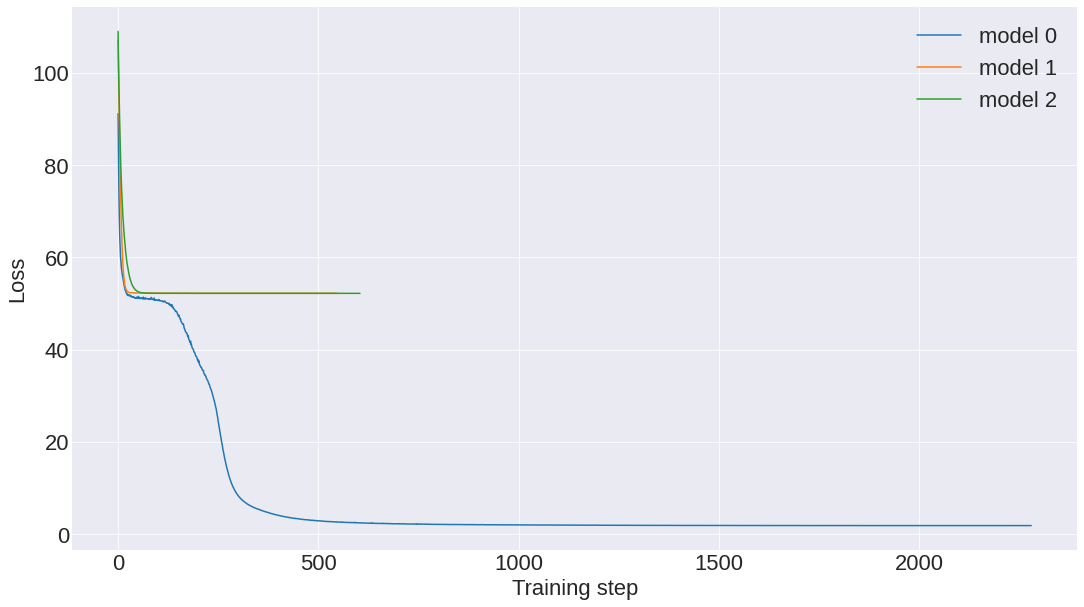

In [ ]:
for i, fit_hist in enumerate(model_fit_hist):
  # print(fit_hist.history.keys())
  loss = fit_hist.history['loss']
  plt.plot(loss, label='model %d' % i)

plt.ylabel('Loss')
plt.xlabel('Training step')
plt.legend()
plt.show()

## Vamos plotar os resultados

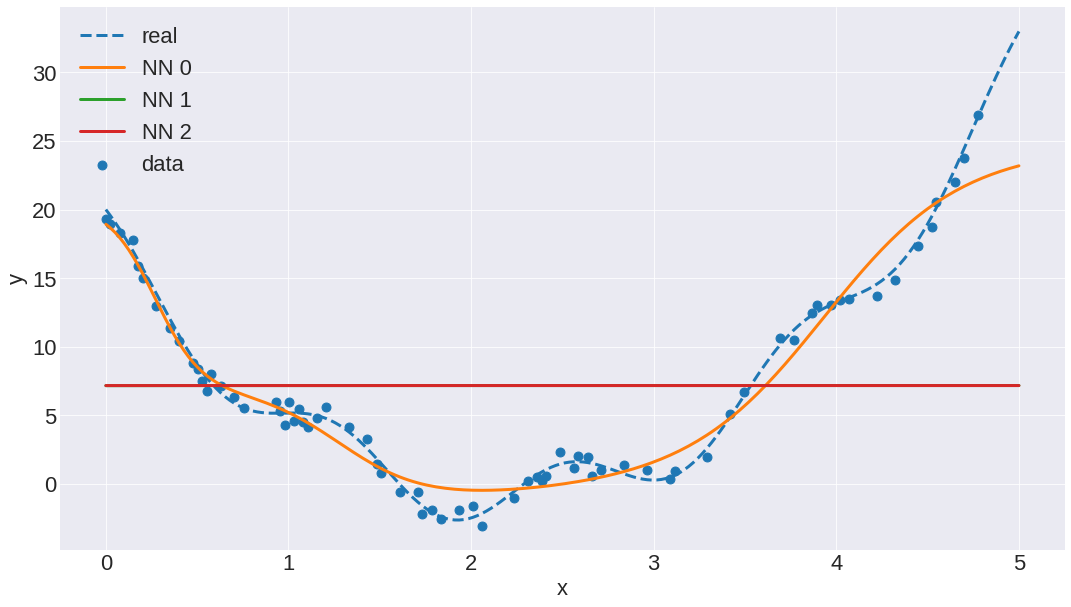

In [ ]:
plt.scatter(x_data, y_data, label='data', s=s)
plt.plot(x, y_real, '--', label='real', lw=lw)

for i, model in enumerate(models_nn[:]):
  plt.plot(x, model.predict(x, verbose=0), label='NN %d' % i, lw=lw)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Vamos analisar o coeficiente de determinação das redes (R²)

In [ ]:
models_r2 = []

for i, model in enumerate(models_nn):
  r2 = r2_score(y_data, model.predict(x_data, verbose=0))
  models_r2.append(r2)
  print('modelo NN %d tem R² = %g' % (i, r2))

best_nn_index = np.argmax(models_r2)
best_nn = models_nn[best_nn_index]

print('\nO Oscar de melhor R² vai para... modelo %d:' % best_nn_index, model_descriptors[best_nn_index])

modelo NN 0 tem R² = 0.965026
modelo NN 1 tem R² = -0.000172045
modelo NN 2 tem R² = -4.7268e-05

O Oscar de melhor R² vai para... modelo 0: [(15, 'tanh')]


# Vamos visualizar o processo de otimização de uma rede

In [ ]:
# modelo com melhor R²
model = models_nn[best_nn_index]  

# histórico da rede com melhor R²
weights_hist = saved_weights_hist[best_nn_index]

y_fit_hist = []

# gera as curvas com os parâmetros do histórico
for i, w in enumerate(weights_hist):
  print('Grerando curva para a iteração %d/%d' % (i, len(weights_hist)))
  model.set_weights(w)
  y_fit_hist.append( model.predict(x, verbose=0) )

Grerando curva para a iteração 0/2281
Grerando curva para a iteração 1/2281
Grerando curva para a iteração 2/2281
Grerando curva para a iteração 3/2281
Grerando curva para a iteração 4/2281
Grerando curva para a iteração 5/2281
Grerando curva para a iteração 6/2281
Grerando curva para a iteração 7/2281
Grerando curva para a iteração 8/2281
Grerando curva para a iteração 9/2281
Grerando curva para a iteração 10/2281
Grerando curva para a iteração 11/2281
Grerando curva para a iteração 12/2281
Grerando curva para a iteração 13/2281
Grerando curva para a iteração 14/2281
Grerando curva para a iteração 15/2281
Grerando curva para a iteração 16/2281
Grerando curva para a iteração 17/2281
Grerando curva para a iteração 18/2281
Grerando curva para a iteração 19/2281
Grerando curva para a iteração 20/2281
Grerando curva para a iteração 21/2281
Grerando curva para a iteração 22/2281
Grerando curva para a iteração 23/2281
Grerando curva para a iteração 24/2281
Grerando curva para a iteração 25/2

KeyboardInterrupt: ignored

In [ ]:
# gera a visualização
import matplotlib.animation as animation
plt.rcParams['animation.embed_limit'] = 2**128
plt.rcParams['animation.html'] = 'jshtml'

plt.scatter(x_data, y_data, label='$y_{data}$', s=s)

# como o histórico pode ser muito grande, vamos pegar a cada "jump" passos
jump = 5
y_hist = y_fit_hist[::jump]

curve, = plt.plot(x, y_hist[0], 'r-', label='$y_{fit}$', lw=lw)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

def animate(frame):
  print('animate: frame %d' % frame)
  return curve.set_ydata(y_hist[frame]), 

anim = animation.FuncAnimation(plt.gcf(), animate, interval=200, save_count=len(y_hist))

anim

# Vamos testar algumas funções de ativação diferentes

Pense: o que isso pode influenciar nos resultados?

In [ ]:
# tangente hiperbólica de LeCun (https://adl1995.github.io/an-overview-of-activation-functions-used-in-neural-networks.html) + função linear
def Atanh(x):
  return 1.7159 * tf.nn.tanh(0.6667 * x) + 0.02 * x

# Radial basis networks are a fancy name for NNs that use radial basis functions (RBF). RBF is a fancy name for a function that depends on a distance to a point
def RBF(x):
  alpha = 2 #10  # você pode testar diferentes valores
  return tf.math.exp( -alpha * x**2 )  # gaussian

# lista com as funções de ativação que vamos testar
# quer incluir ou substituir alguma?
activations = [
    tf.keras.activations.relu,
    tf.keras.activations.tanh,
    tf.keras.activations.sigmoid,
    tf.keras.activations.swish,
    Atanh,
    RBF,
]

# pega o melhor modelo
best_nn_descriptor = model_descriptors[best_nn_index]

# lista para guardar os descritores dos modelos com as novas funções de ativação
models_nn_act = []

# substitui a função de ativação nas camadas de best_nn_descriptor
model_descriptors_act = [[(layer_desc[0], activ) for layer_desc in best_nn_descriptor] for activ in activations]
print(model_descriptors_act)

for model_desc in model_descriptors_act:
  model =  tf.keras.Sequential()
  model.add( tf.keras.layers.InputLayer((1,)) )
  for layer_desc in model_desc:
    model.add( tf.keras.layers.Dense(layer_desc[0], activation=layer_desc[1]) )
  model.add( tf.keras.layers.Dense(1, activation='linear') )

  models_nn_act += [model]

  print('---------------------------------------------------------')
  print('Modelo:', model_desc)
  print(model.summary())
  for layer in model.layers:
    print(layer.get_config())
  print('\n\n')

[[(15, <function relu at 0x7f8fa7eb95e0>)], [(15, <function tanh at 0x7f8fa7eb9940>)], [(15, <function sigmoid at 0x7f8fa7eb9af0>)], [(15, <function swish at 0x7f8fa7eb9430>)], [(15, <function Atanh at 0x7f8f9b2adc10>)], [(15, <function RBF at 0x7f8fa335a670>)]]
---------------------------------------------------------
Modelo: [(15, <function relu at 0x7f8fa7eb95e0>)]
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 15)                30        
                                                                 
 dense_10 (Dense)            (None, 1)                 16        
                                                                 
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________
None
{'name': 'dense_9', 'trainable': True, 'dtype': 'float32', 'units': 15, 'activ

# Vamos dar uma olhada nessas funções de ativação

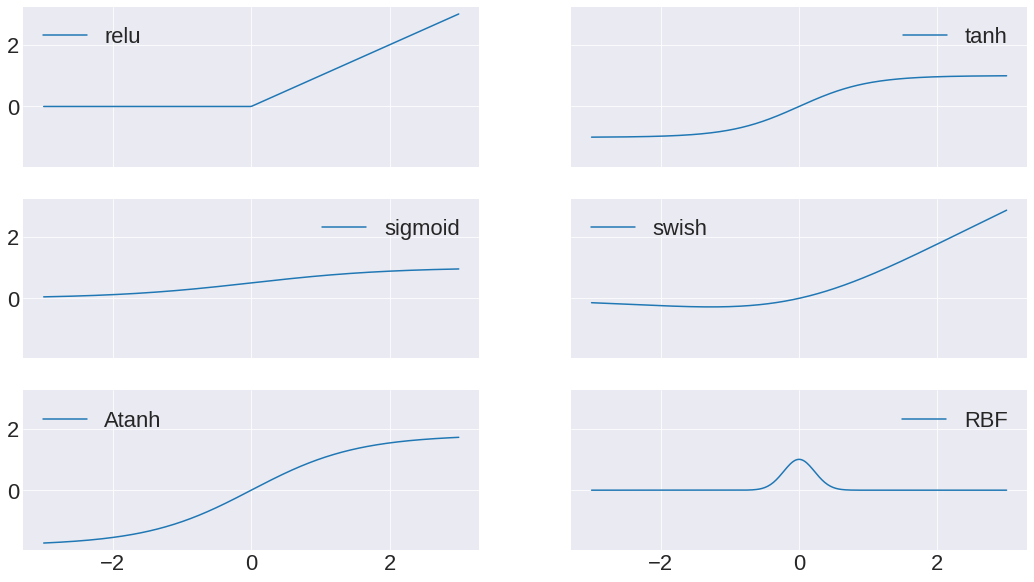

In [ ]:
# grafica as funções
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)

for ax, activation in zip(axs.ravel(), activations):
  x_ = np.linspace(-3., 3., 300)
  ax.plot(x_, activation(x_), label=activation.__name__)
  ax.legend()

In [ ]:
# treino
n_epochs = 4000
bs = 12

for model, model_desc in zip(models_nn_act, model_descriptors_act):
  lr = 1e-2 #tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=1000, decay_rate=0.99)
  opt = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
  loss = tf.keras.losses.MeanSquaredError()
  # this is to get learning rate to be printed while training
  lr_metric = lambda y_true, y_pred: opt._decayed_lr(tf.float32)
  metrics = ['mae', lr_metric]

  model.compile(optimizer=opt, loss=loss, metrics=metrics)

  print('\n\n\n--------------------------------')
  print('Fitting', model_desc, '\n')

  model.fit(x_data, y_data, epochs=n_epochs, batch_size=bs, callbacks=callbacks, shuffle=True, verbose=2)

Streaming output truncated to the last 5000 lines.
Epoch 690/4000
6/6 - 0s - loss: 2.3859 - mae: 1.2838 - <lambda>: 0.0051 - lr: 0.0051 - 25ms/epoch - 4ms/step
Epoch 691/4000
6/6 - 0s - loss: 2.3856 - mae: 1.2855 - <lambda>: 0.0051 - lr: 0.0051 - 20ms/epoch - 3ms/step
Epoch 692/4000
6/6 - 0s - loss: 2.3835 - mae: 1.2805 - <lambda>: 0.0051 - lr: 0.0051 - 20ms/epoch - 3ms/step
Epoch 693/4000
6/6 - 0s - loss: 2.3785 - mae: 1.2792 - <lambda>: 0.0041 - lr: 0.0041 - 20ms/epoch - 3ms/step
Epoch 694/4000
6/6 - 0s - loss: 2.3834 - mae: 1.2799 - <lambda>: 0.0041 - lr: 0.0041 - 19ms/epoch - 3ms/step
Epoch 695/4000
6/6 - 0s - loss: 2.3716 - mae: 1.2767 - <lambda>: 0.0041 - lr: 0.0041 - 19ms/epoch - 3ms/step
Epoch 696/4000
6/6 - 0s - loss: 2.3719 - mae: 1.2845 - <lambda>: 0.0041 - lr: 0.0041 - 21ms/epoch - 3ms/step
Epoch 697/4000
6/6 - 0s - loss: 2.3794 - mae: 1.2879 - <lambda>: 0.0041 - lr: 0.0041 - 19ms/epoch - 3ms/step
Epoch 698/4000
6/6 - 0s - loss: 2.3722 - mae: 1.2761 - <lambda>: 0.0041 - lr:

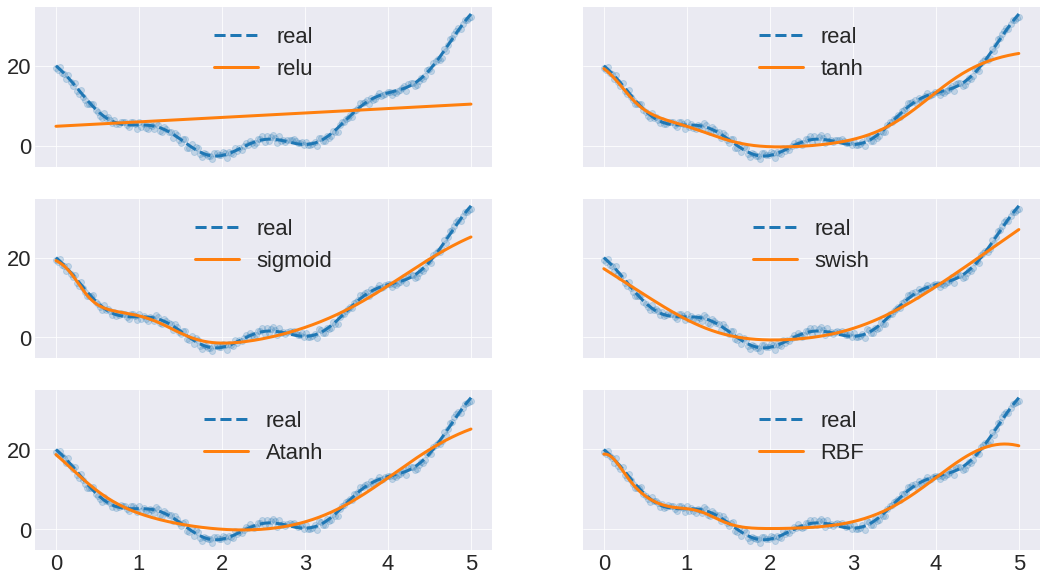

In [ ]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)

for ax, activation, nn in zip(axs.ravel(), activations, models_nn_act):
  ax.scatter(x, y_noisy, alpha=0.2)
  ax.plot(x, y_real, '--', label='real', lw=lw)
  ax.plot(x, nn.predict(x, verbose=0), label=activation.__name__, lw=lw)
  ax.legend()

In [ ]:
models_act_r2 = []

for i, model in enumerate(models_nn_act):
  r2 = r2_score(y_data, model.predict(x_data, verbose=0))
  models_act_r2.append(r2)
  print('modelo NN %d tem R²=%g' % (i, r2))

best_act_index = np.argmax(models_act_r2)
best_act = models_nn_act[best_act_index]

print('\nMelhor R²: activação %d: %s' % (best_act_index, activations[best_act_index].__name__))

modelo NN 0 tem R²=0.0466097
modelo NN 1 tem R²=0.96243
modelo NN 2 tem R²=0.971138
modelo NN 3 tem R²=0.951351
modelo NN 4 tem R²=0.9564
modelo NN 5 tem R²=0.961372

Melhor R²: activação 2: sigmoid
